In [198]:
# Price of a European option using the Black–Scholes model
# Here we consider such an option with Apple as the underlying asset

# The pricing parameters are: the spot price, the strike, the implied volatility,
# the risk-free interest rate, dividends, and maturity

# Let us start by obtaining the parameters for which the data is available and up to date


In [199]:
import yfinance as yf
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We start with the spot:

ticker = yf.Ticker("AAPL")
M= ticker.history(period="1d")
S = ticker.history(period="1d")["Close"].iloc[-1]

print(M)
print("\n\nSpot AAPL:", S)


                                 Open        High         Low       Close  \
Date                                                                        
2026-01-30 00:00:00-05:00  255.169998  261.899994  252.179993  259.480011   

                             Volume  Dividends  Stock Splits  
Date                                                          
2026-01-30 00:00:00-05:00  92352600        0.0           0.0  


Spot AAPL: 259.4800109863281


In [200]:
# Then the risk-free interest rate 
# For US treasuries: ^IRX -> 3M  ;  ^FVX -> 5Y  ;  ^TNX -> 10Y  . ^TYX -> 30Y

import yfinance as yf

ticker_taux = yf.Ticker("^IRX")  # T-bill 13 semaines
rate = ticker_taux.history(period="1d")["Close"].iloc[-1] / 100
print(rate)


0.03572000026702881


In [201]:
# Finally, the implied volatility

expiry = ticker.options[0]  # la plus proche maturité
options = ticker.option_chain(expiry)
calls = options.calls
calls = calls[['strike', 'impliedVolatility']].dropna()

# Exemple : prendre la vol implicite du call ATM le plus proche
atm_call = calls.iloc[(calls['strike'] - S).abs().argsort()[:1]]
sigma = atm_call['impliedVolatility'].values[0]

print(sigma)



0.213875048828125


In [202]:
# Let us write the pricing function for a European call/put option

def BS_price(S, K, T, r, q, sigma, option_type="call"):

    d1 = (np.log(S / K) + (r-q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == "call":
        price = S * np.exp(-q * T) *norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S* np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")

    return price

In [203]:
# Let us test our function:

call_price=BS_price(S,250,0.5,rate,0,sigma,"call")
put_price=BS_price(S,250,0.5,rate,0,sigma,"put")

print("Call:", call_price)
print("Put:", put_price)

Call: 23.17017342520691
Put: 9.264798538205582


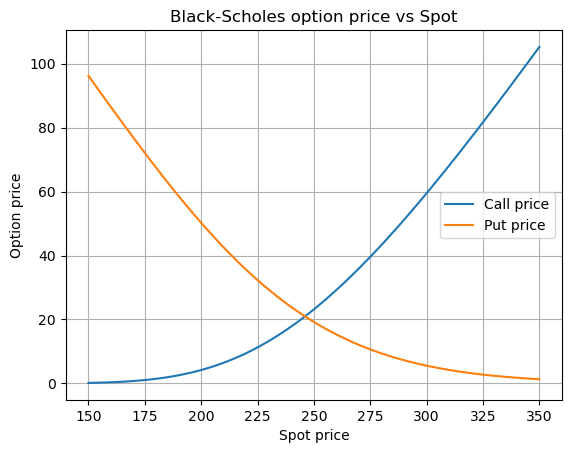

Here, the strike is set to 255 for both curves


In [204]:
S_grid = np.linspace(150, 350, 200)

call_prices = []
put_prices  = []

for S in S_grid:
    call_prices.append(BS_price(S, 255, 1, rate, 0, sigma, "call"))
    put_prices.append( BS_price(S, 255, 1, rate, 0, sigma, "put"))


plt.figure()
plt.plot(S_grid, call_prices, label="Call price")
plt.plot(S_grid, put_prices, label="Put price")
plt.xlabel("Spot price")
plt.ylabel("Option price")
plt.title("Black-Scholes option price vs Spot")
plt.legend()
plt.grid(True)
plt.show()

print("Here, the strike is set to 255 for both curves")

In [205]:
# Let us write the formulas for the Greeks under the assumptions of the Black–Scholes model:

def BS_greeks(S, K, T, r, q, sigma, option_type="call"):
    
    d1 = (np.log(S / K) + (r-q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    pdf = norm.pdf(d1)

    # Greeks communs
    gamma = np.exp(-q*T) * pdf / (S * sigma * np.sqrt(T))
    vega  = S * np.exp(-q*T) * pdf * np.sqrt(T)

    if option_type.lower() == "call":
        delta = np.exp(-q*T) * norm.cdf(d1)
        theta = (-S * np.exp(-q*T) * pdf * sigma / (2*np.sqrt(T))
                 - r*K*np.exp(-r*T)*norm.cdf(d2)
                 + q*S*np.exp(-q*T)*norm.cdf(d1))
        rho = K * T * np.exp(-r*T) * norm.cdf(d2)

    elif option_type.lower() == "put":
        delta = -np.exp(-q*T) * norm.cdf(-d1)
        theta = (-S * np.exp(-q*T) * pdf * sigma / (2*np.sqrt(T))
                 + r*K*np.exp(-r*T)*norm.cdf(-d2)
                 - q*S*np.exp(-q*T)*norm.cdf(-d1))
        rho = -K * T * np.exp(-r*T) * norm.cdf(-d2)

    else:
        raise ValueError("option_type doit être 'call' ou 'put'")

    return {
        "delta": float(delta),
        "gamma": float(gamma),
        "vega": float(vega),
        "theta": float(theta),
        "rho": float(rho)
        }


In [207]:
# Let us test our function:

call_greeks=BS_greeks(S,255,1,rate,0.05,sigma,"call")
put_greeks=BS_greeks(S,260,1,rate,0.03,sigma,"put")

df=pd.DataFrame({'Call':call_greeks, 'Put':put_greeks})
print(df)

             Call        Put
delta    0.890203  -0.061928
gamma    0.001595   0.001620
vega    41.786796  42.454754
theta    3.161392  -4.337513
rho    222.524816 -23.872947


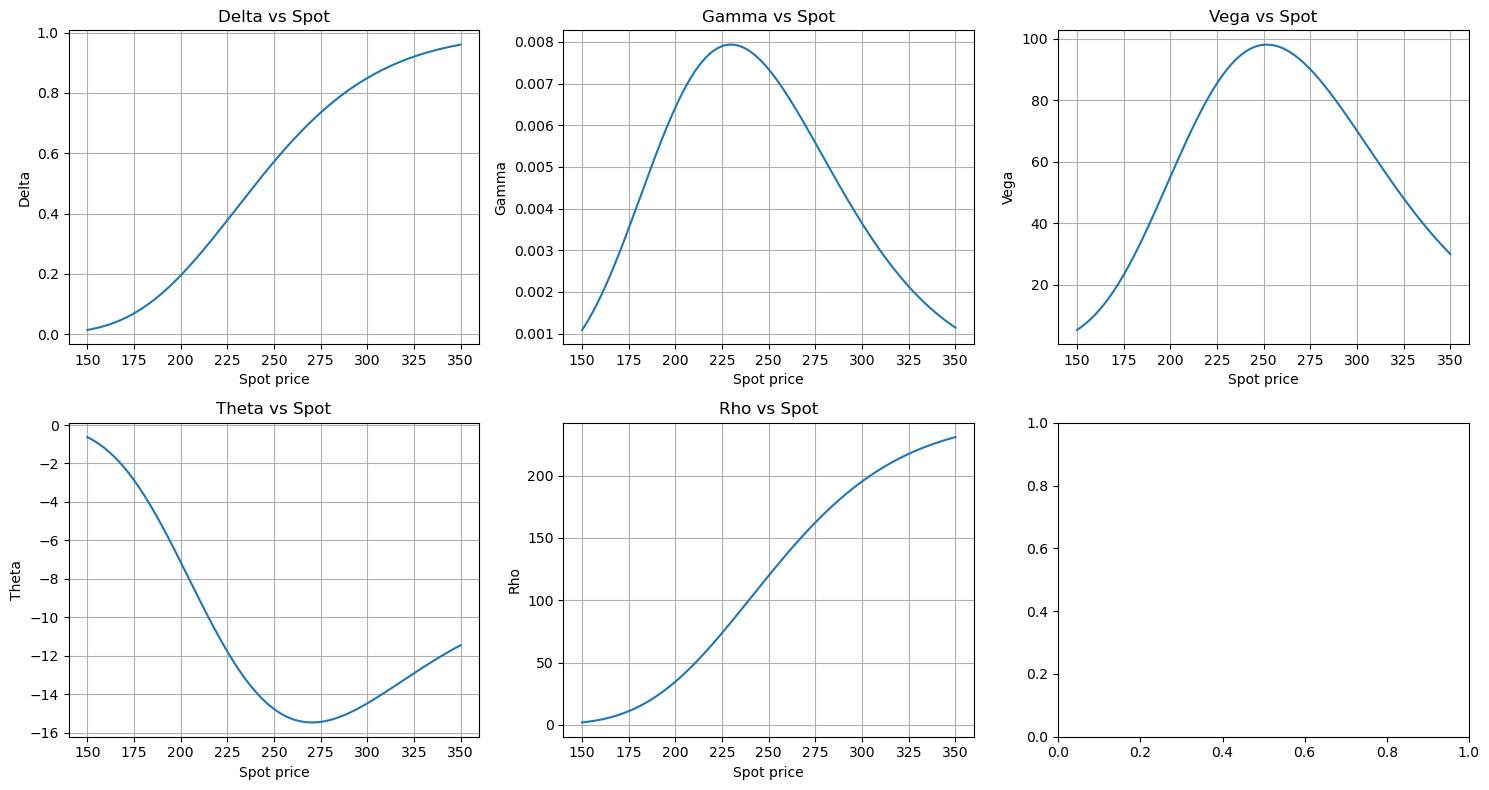

In [191]:
# Greeks vs spot:

S_grid = np.linspace(150, 350, 200)

greeks = {
    'delta': [],
    'gamma': [],
    'vega': [],
    'theta': [],
    'rho': []
}

for S in S_grid:
    g = BS_greeks(S, 255, 1, rate,0, sigma, "call")
    for k in greeks:
        greeks[k].append(g[k])

# Graphique:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i, (greek, values) in enumerate(greeks.items()):
    axs[i].plot(S_grid, values)
    axs[i].set_title(f"{greek.capitalize()} vs Spot")
    axs[i].set_xlabel("Spot price")
    axs[i].set_ylabel(greek.capitalize())
    axs[i].grid(True)

plt.tight_layout()
plt.show()


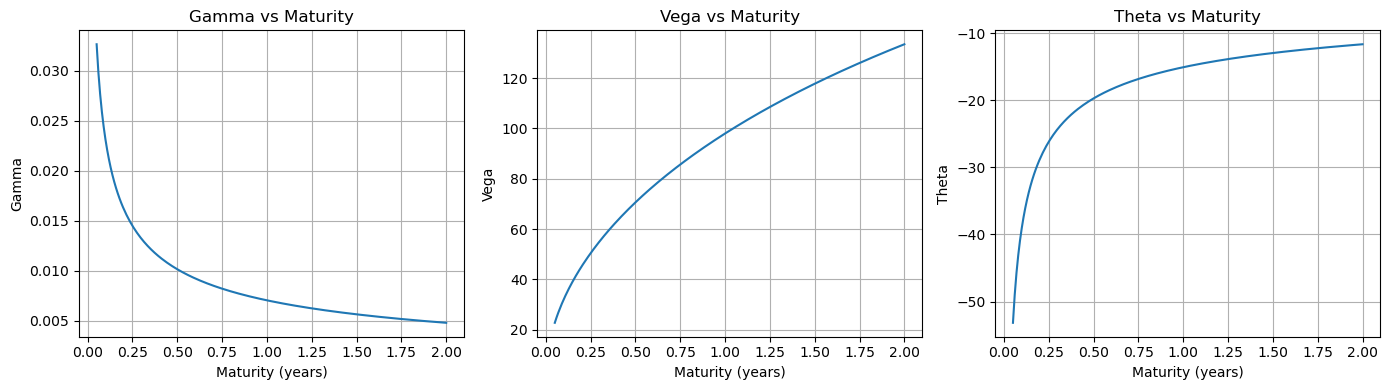

In [190]:
# Greeks vs maturity:
T_grid = np.linspace(0.05, 2, 200)

greeks_T = {
    'gamma': [],
    'vega': [],
    'theta': []
}

for T in T_grid:
    g = BS_greeks(255, 255, T, rate,0, sigma, "call")
    for k in greeks_T:
        greeks_T[k].append(g[k])

# Graphique
fig,axs=plt.subplots(1,3,figsize=(14,4))
axs=axs.flatten()

for i, (greek, values) in enumerate(greeks_T.items()):
    axs[i].plot(T_grid, values)
    axs[i].set_title(f"{greek.capitalize()} vs Maturity")
    axs[i].set_xlabel("Maturity (years)")
    axs[i].set_ylabel(f"{greek.capitalize()}")
    axs[i].grid(True)
    
plt.tight_layout()
plt.show()
